In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from io import StringIO
import os
import csv
import sys
import glob

%matplotlib inline 

import xlsxwriter
from scipy import stats

import seaborn as sns
# from pandas.tools import plotting
from matplotlib import pyplot as plt

In [7]:
workdir= os.curdir

In [10]:
cd ../sum

/Users/ltao/Projects/b_STR_lineage/Exp/190510-mips/sum


In [15]:
ls

190510_samples.csv
190510_samples_bcid.csv
miseq190510_finalized_fmsv_summary_merged.xlsx
miseq190510_fmsv_summary_merged.xlsx


# Try a diffrernt approach::: Dict is more flexible than pandas functions

In [19]:

sample_sheet_bcid='190510_samples_bcid.csv'
fmsv_summary_merged='miseq190510_fmsv_summary_merged.xlsx'
sheets = pd.read_excel(fmsv_summary_merged, sheet_name=None)
panel_srid=dict()
for sheet_name, sheet in sheets.items():
    panel_srid[sheet_name]= sheet['Locus'].values.tolist()


# panel_official_name={"om6":"om6_only","mito":"limingmito","swanton":"swanton_6_candidates"}
panel_official_name={"OM6":"om6_only","Yehud":"BLAINEY_SNPS_PANEL","Swanton":"swanton_6_candidates","OMXIII":"OMW-4"}


In [22]:



##### function to get a summery 

def get_summary(merged_sheet, sample_name='Name'):
    tt=merged_sheet
#     tt=tt.set_index('bcid')
    tt=tt.set_index(sample_name)
    
    od=tt.to_dict("index")
    
    for key, item in od.items():
        success_reads=0
        loci_count =0
        loci_threshold=0
        panel_setting = item['Panel']
        if 'plus' in panel_setting:
            tmp = panel_setting.split('_')
            panel_a= panel_official_name[tmp[0]]
            panel_b=panel_official_name[tmp[-1]]
            a_loci_count_panel=0
            b_loci_count_panel=0
    
            for k, it in item.items():
                if type(k) is  int:
                    if it > 0:
                        if k in panel_srid[panel_a]:
                            a_loci_count_panel = a_loci_count_panel + 1
                        elif k in panel_srid[panel_b]:
                            b_loci_count_panel = b_loci_count_panel + 1
                        else:
                            pass
        for k, it in item.items():
            if type(k) is  int:
                if it > 0:
                    success_reads=success_reads+it
                    if it > loci_threshold:
                        loci_count = loci_count + 1
        od[key]['SuccessReads']=success_reads
        
        
        if item['TotalReads'] > 0:
            od[key]['SuccessRate'] = success_reads/item['TotalReads']
        loci_count_key='Loci>{thr}'.format(thr=str(loci_threshold))
        od[key][loci_count_key] =loci_count

        if 'plus' in panel_setting:

            aloci_count_key='{p}_Loci>{thr}'.format(thr=str(loci_threshold),p=panel_a)
            bloci_count_key='{p}_Loci>{thr}'.format(thr=str(loci_threshold),p=panel_b)
            abloci_count_key='{p1}:{p2}'.format(p1=panel_a,p2=panel_b)
    
            od[key][aloci_count_key]  =a_loci_count_panel
            od[key][bloci_count_key] =b_loci_count_panel
            if b_loci_count_panel > 0:
                od[key][abloci_count_key] =a_loci_count_panel/b_loci_count_panel
    for key, item in od.items():
        print (key)
        for k, it in item.items():
            if type(k) is not int:
                print (k,':    ',it)
        print  ()
    df=pd.DataFrame.from_dict(od, orient='index')
    ### Draw bar plot to compare 
    npa1 = np.array(["TotalReads",'SuccessReads','SuccessRate',  'Loci>0'])
# npa1 = np.array(['CellName','TotalReads', 'Success Reads','Success Rate',  'Loci>0'])

# columns_to_write

    sum_sheet=df[npa1]

    plt.rcParams['figure.figsize'] = [16, 6]
    ax = sum_sheet.plot.bar(secondary_y='SuccessRate',rot=90)
    plt.xlabel("")
    plt.title(sheet_name)
    plt.savefig(sheet_name, bbox_inches='tight',dpi=600)
    return (df)

hudy_400nM_3_7
Panel :     Yehud
Cell ID :     1063
Barcodes :     73
Barcodes_Content_id :     25592
bcid :     25592
TotalReads :     14131.0
SuccessReads :     11558.0
SuccessRate :     0.8179180525086689
Loci>0 :     1939

hudy_400nM_4_5
Panel :     Yehud
Cell ID :     1063
Barcodes :     74
Barcodes_Content_id :     25593
bcid :     25593
TotalReads :     21063.0
SuccessReads :     16058.0
SuccessRate :     0.7623795280824194
Loci>0 :     2139

hudy_400nM_4_8
Panel :     Yehud
Cell ID :     1063
Barcodes :     75
Barcodes_Content_id :     25594
bcid :     25594
TotalReads :     14177.0
SuccessReads :     10795.0
SuccessRate :     0.7614445933554349
Loci>0 :     1890

hudy_400nM_5_4
Panel :     Yehud
Cell ID :     1063
Barcodes :     76
Barcodes_Content_id :     25595
bcid :     25595
TotalReads :     46837.0
SuccessReads :     36084.0
SuccessRate :     0.7704165510173581
Loci>0 :     3408

hudy_400nM_5_6
Panel :     Yehud
Cell ID :     1063
Barcodes :     77
Barcodes_Content_id : 

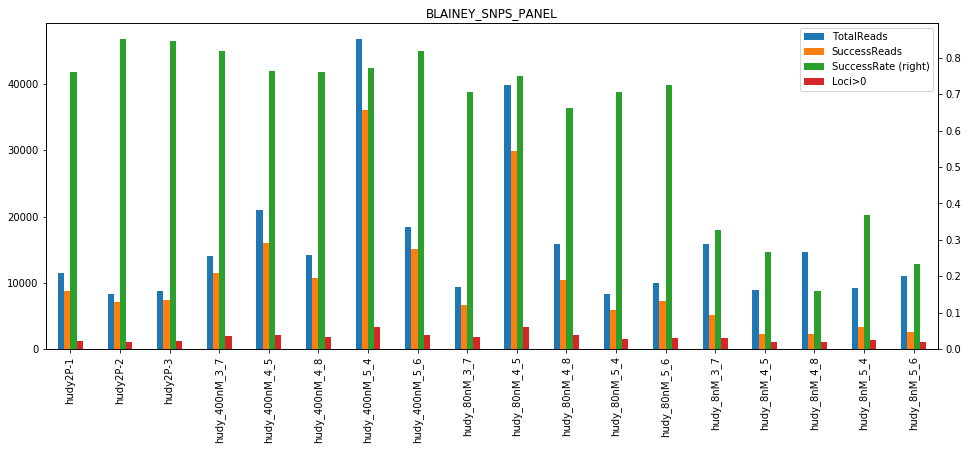

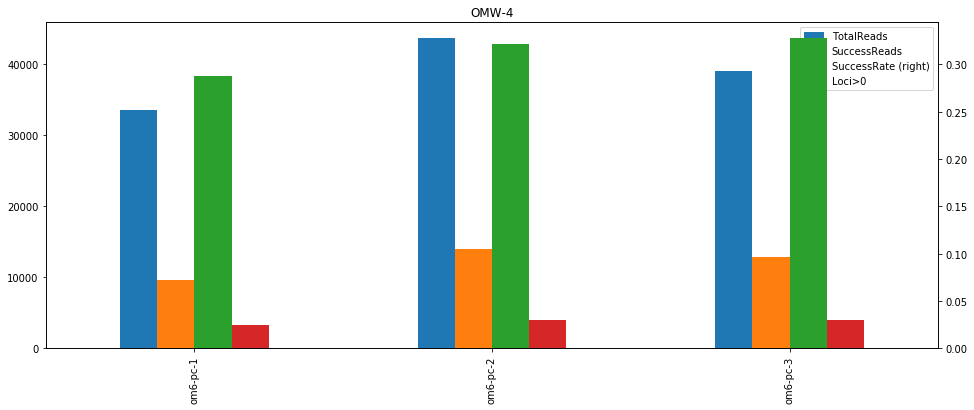

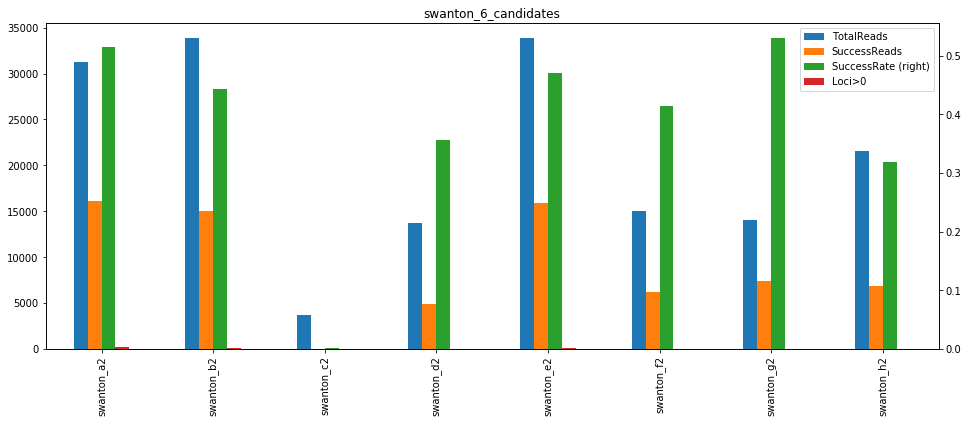

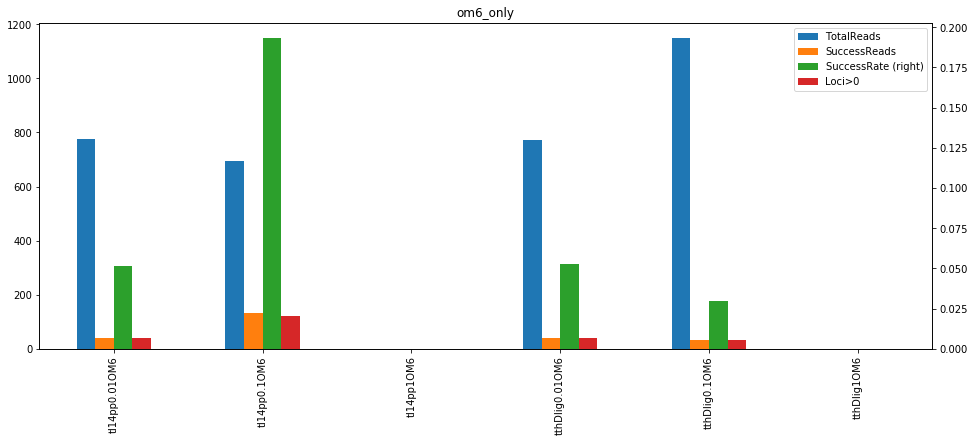

In [23]:
sheets = pd.read_excel(fmsv_summary_merged, sheet_name=None)
sheets_tp=dict()


for sheet_name, sheet in sheets.items():
    sheet.columns.values[0]='bcid' ## this is to correct the error from summary table
#     print ( sheet_name, '\n' , sheet.head(5))
    sheet_tp=sheet.transpose()
    sheet_tp=sheet_tp.reset_index()
    sheet_tp.columns = sheet_tp.iloc[0]
    sheet_tp=sheet_tp.reindex(sheet_tp.index.drop(0))
    sheet_tp['bcid']=sheet_tp['bcid'].apply(int)
#     sheet_tp=sheet_tp.loc[sheet_tp['TotalReads'] > 0]
    sheets_tp[sheet_name]= sheet_tp
#     print ( sheet_name, '\n' , sheet_tp.head(1))
sample_sheet = pd.read_csv(sample_sheet_bcid)
sample_sheet.columns.values[-1]='bcid' ##drop the second bcid in the future sumery table generator
sample_sheet['bcid']=sample_sheet['bcid'].apply(int)
# sample_sheet.head(1)
merged_sheets=dict()
for sheet_name, sheet_tp in sheets_tp.items():
    merged_sheet=pd.merge(sample_sheet, sheet_tp, on='bcid')
    merged_sheets[sheet_name]= merged_sheet
    
sum_sheets=dict()
for sheet_name, merged_sheet in merged_sheets.items():
    sum_sheets[sheet_name]= get_summary(merged_sheet,sample_name='Name')

In [24]:
writer = pd.ExcelWriter('only_sum.xlsx', engine='xlsxwriter')

# writer = pd.ExcelWriter('sum_sheets.xlsx', engine='xlsxwriter')
for sheet_name, sum_sheet in sum_sheets.items():
# Write each dataframe to a different worksheet.
    columns_to_write=[col for col in sum_sheet.columns.values if  type(col) is str]
    sum_sheet=sum_sheet[columns_to_write]
    sum_sheet.to_excel(writer, sheet_name=sheet_name)
# Close the Pandas Excel writer and output the Excel file.
writer.save()

In [25]:
# writer = pd.ExcelWriter('only_sum.xlsx', engine='xlsxwriter')

writer = pd.ExcelWriter('sum_sheets.xlsx', engine='xlsxwriter')
for sheet_name, sum_sheet in sum_sheets.items():
# Write each dataframe to a different worksheet.
#     columns_to_write=[col for col in sum_sheet.columns.values if  type(col) is str]
#     sum_sheet=sum_sheet[columns_to_write]
    sum_sheet.to_excel(writer, sheet_name=sheet_name)
# Close the Pandas Excel writer and output the Excel file.
writer.save()